In [108]:
import sys  
sys.path.insert(0, './machine_learning_models')

import os
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import clear_output
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.preprocessing import StandardScaler
from helpers.file import save_file
from joblib import dump
pd.set_option('mode.chained_assignment', None)

In [109]:
first_season = 2012
last_season = 2023

save_models = False

season_file = f'{first_season}-{last_season}'

min_odds = 1.8

first_attr_index = 6
target_index = -3

In [110]:
print('\nGetting data for the model...')

dataset = pd.read_csv('../data/{}.csv'.format(season_file), index_col = 0)
dataset = dataset.loc[(dataset['ODDS_A'].notna()) & (dataset['ODDS_B'].notna())]
dataset['GAME_DATE'] = pd.to_datetime(dataset['GAME_DATE']).dt.date

display(dataset.tail(2))


Getting data for the model...


,SEASON_ID,GAME_DATE,TEAM_A,TEAM_B,ODDS_A,ODDS_B,PTS_A,PTS_CON_A,FG_PCT_A,FG3_PCT_A,...,HA_B_PCT,STREAK_B,LAST_GAMES_PCT_B,HA_LAST_GAMES_PCT_B,OFF_RTG_B,DEF_RTG_B,IS_B2B_B,WINNER,GAME_PTS_A,GAME_PTS_B
12226,2023,2024-03-01,CHI,MIL,2.37,1.60,116.4,116.7,0.4634,0.3500,...,0.517241,4,0.6,0.6,114.665357,107.691833,True,A,97,113
12227,2023,2024-03-01,LAC,WAS,1.07,8.77,112.7,117.1,0.4730,0.3697,...,0.193548,-13,0.0,0.0,105.732753,116.419216,True,H,140,115


In [111]:
# dependent_variables = dataset.iloc[:,first_attr_index:]
# dependent_variables.corr()

In [112]:
def train_predict_model(x_train, y_train, x_test, y_test, season, model):
    model_abbv = model['abbreviation']
    classifier = model['classifier']
    
    classifier.fit(x_train, y_train)
    predictions = classifier.predict(x_test)
    predictions_probabilities = classifier.predict_proba(x_test)
    
    if save_models and season == last_season:
        save_file('../models', classifier, model_abbv)
    
    results_df = pd.DataFrame({
        f"{model_abbv}_PRED": predictions,
        f"{model_abbv}_PROBS_A": predictions_probabilities[:, 1],
        f"{model_abbv}_PROBS_B": predictions_probabilities[:, 0],
    })
    
    return results_df

In [113]:
columns = dataset.columns[first_attr_index:target_index]

save_file('../columns', columns, 'original')

columns_to_drop = []
columns = [c for c in columns if c not in columns_to_drop]

save_file('../columns', columns, 'filtered')

target_col = dataset.columns[target_index]

print('Columns:', columns)
print('Target:', target_col)

Columns: ['PTS_A', 'PTS_CON_A', 'FG_PCT_A', 'FG3_PCT_A', 'FT_PCT_A', 'REB_A', 'TOV_A', 'SEASON_A_PCT', 'PER_A', 'ELO_A', 'MATCHUP_A_PCT', 'HA_A_PCT', 'STREAK_A', 'LAST_GAMES_PCT_A', 'HA_LAST_GAMES_PCT_A', 'OFF_RTG_A', 'DEF_RTG_A', 'IS_B2B_A', 'PTS_B', 'PTS_CON_B', 'FG_PCT_B', 'FG3_PCT_B', 'FT_PCT_B', 'REB_B', 'TOV_B', 'SEASON_B_PCT', 'PER_B', 'ELO_B', 'MATCHUP_B_PCT', 'HA_B_PCT', 'STREAK_B', 'LAST_GAMES_PCT_B', 'HA_LAST_GAMES_PCT_B', 'OFF_RTG_B', 'DEF_RTG_B', 'IS_B2B_B']
Target: WINNER


In [114]:
main_df = pd.DataFrame()

for season in range(first_season + 1, last_season+1):
    rf_classifier = RandomForestClassifier(n_estimators=500, random_state=0)
    gb_classifier = GradientBoostingClassifier(random_state=0)
    lr_classifier = LogisticRegression()
    svm_classifier = SVC(kernel='rbf', random_state=0, probability=True)
    sgd_classifier = SGDClassifier(loss="log", random_state = 0)

    # Create a voting classifier
    voting_classifier = VotingClassifier(
        estimators=[
            ('LR', lr_classifier),
            ('GB', gb_classifier),
            ('RF', rf_classifier),
        ],
        voting='soft'  # Use 'soft' for probability voting
    )
    
    models = [
        {'classifier': rf_classifier, 'abbreviation': 'RF'},
        {'classifier': RandomForestClassifier(n_estimators=200, random_state=0), 'abbreviation': 'RF_200'},
        {'classifier': RandomForestClassifier(n_estimators=800, random_state=0), 'abbreviation': 'RF_800'},
        {'classifier': gb_classifier, 'abbreviation': 'GB'},
        {'classifier': svm_classifier, 'abbreviation': 'SVM'},
        {'classifier': lr_classifier, 'abbreviation': 'LR'},
        {'classifier': voting_classifier, 'abbreviation': 'VC'},
        {'classifier': GaussianNB(), 'abbreviation': 'NB'},
        {'classifier': KNeighborsClassifier(n_neighbors=500), 'abbreviation': 'KNN'},
        {'classifier': sgd_classifier, 'abbreviation': 'SGD'}, 
    ]

    train_dataset = dataset[dataset['SEASON_ID'] < season]
    x_train = train_dataset[columns]
    y_train = train_dataset[target_col]

    test_dataset = dataset[dataset['SEASON_ID'] == season]
    x_test = test_dataset[columns]
    y_test = test_dataset[target_col]

    scaler = StandardScaler()
    x_train_scaled = scaler.fit_transform(x_train)
    x_test_scaled = scaler.transform(x_test)
    
    if save_models and season == last_season:
        save_file('../scalers', scaler, 'scaler')
    
    for model in models:
        clear_output(wait=True)
        
        model_abbv = model["abbreviation"]
        print(f"{season}/{last_season} - {model_abbv}")
        
        results_df = train_predict_model(x_train_scaled, y_train, x_test_scaled, y_test, season, model)
        results_df.set_index(test_dataset.index, inplace=True)
        
        test_dataset = pd.merge(test_dataset, results_df, left_index=True, right_index=True)

    if main_df.empty:
        main_df = test_dataset
    else:
        main_df = pd.concat([main_df, test_dataset], ignore_index=True)

2023/2023 - SGD


In [115]:
def create_game_profit_col(row, model_abbv):
    odds = row["ODDS_A" if row[f"{model_abbv}_PRED"] == "H" else "ODDS_B"]
    pred_odds = 1 / (
        row[
            f"{model_abbv}_PROBS_A"
            if row[f"{model_abbv}_PRED"] == "H"
            else f"{model_abbv}_PROBS_B"
        ]
    )
    probs = row[
        f"{model_abbv}_PROBS_A"
        if row[f"{model_abbv}_PRED"] == "H"
        else f"{model_abbv}_PROBS_B"
    ]

    bet_valid = odds >= min_odds and pred_odds < odds

    if bet_valid and row["WINNER"] == row[f"{model_abbv}_PRED"]:
        return odds - 1
    elif bet_valid:
        return -1
    else:
        return 0


display(main_df.head(2))

in_depth_models_for_analysis = ["RF", "RF_800", "RF_200", "RF_500", "GB", "SVM", "LR", "VC", "SGD"]

# Initialize an empty DataFrame to store season-wise statistics
season_stats = pd.DataFrame(columns=["Season"])

for model in models:
    model_abbv = model["abbreviation"]

    main_df[f"{model_abbv}_PROFIT"] = main_df.apply(
        lambda x: create_game_profit_col(x, model_abbv), axis=1
    )
    main_df[f"{model_abbv}_PROFIT_TRACKING"] = main_df[f"{model_abbv}_PROFIT"].cumsum()
    main_df[f"{model_abbv}_STRIKE"] = (
        main_df[f"{model_abbv}_PRED"] == main_df["WINNER"]
    ).astype(int)

    # Calculate Net Gains
    net_gains = main_df[f"{model_abbv}_PROFIT_TRACKING"].iloc[-1]

    # Calculate Yield
    total_profit = main_df[f"{model_abbv}_PROFIT_TRACKING"].iloc[-1]
    total_bets = len(main_df)
    yield_percentage = (total_profit / total_bets) * 100

    # Calculate Strike Rate
    correct_predictions = main_df[f"{model_abbv}_STRIKE"].sum()
    strike_rate_percentage = (correct_predictions / total_bets) * 100

    # Print the results
    print(f"\n{model_abbv} Net Gains: {net_gains}")
    print(f"{model_abbv} Yield: {yield_percentage:.2f}%")
    print(f"{model_abbv} Strike Rate: {strike_rate_percentage:.2f}%")

    if model_abbv not in in_depth_models_for_analysis:
        continue

    # Group by season and calculate overall stats
    model_season_stats = main_df.groupby("SEASON_ID").agg(
        {
            f"{model_abbv}_PROFIT_TRACKING": lambda x: x.iloc[-1] - x.iloc[0],
            f"{model_abbv}_PROFIT": lambda x: (
                x != 0
            ).sum(),  # Counting only non-zero profits as bets
        }
    )

    # Rename columns for clarity
    model_season_stats.columns = [f"{model_abbv}_Net_Gains", f"{model_abbv}_Total_Bets"]

    # Calculate additional statistics
    model_season_stats[f"{model_abbv}_Yield"] = (
        model_season_stats[f"{model_abbv}_Net_Gains"]
        / model_season_stats[f"{model_abbv}_Total_Bets"]
    ) * 100

    # Merge with the overall season_stats DataFrame
    season_stats = pd.merge(
        season_stats,
        model_season_stats,
        left_on="Season",
        right_index=True,
        how="outer",
    )

season_stats.drop("Season", axis=1, inplace=True)

,SEASON_ID,GAME_DATE,TEAM_A,TEAM_B,ODDS_A,ODDS_B,PTS_A,PTS_CON_A,FG_PCT_A,FG3_PCT_A,...,VC_PROBS_B,NB_PRED,NB_PROBS_A,NB_PROBS_B,KNN_PRED,KNN_PROBS_A,KNN_PROBS_B,SGD_PRED,SGD_PROBS_A,SGD_PROBS_B
0,2013,2013-11-16,MIN,BOS,1.18,5.03,108.7,101.4,0.4437,0.3571,...,0.162213,H,0.997184,0.002816,H,0.704,0.296,H,0.998660,0.001340
1,2013,2013-11-18,DAL,PHI,1.10,7.27,106.6,103.6,0.4708,0.3986,...,0.160739,H,0.999811,0.000189,H,0.720,0.280,H,0.965996,0.034004



RF Net Gains: -84.17999999999996
RF Yield: -0.75%
RF Strike Rate: 65.46%

RF_200 Net Gains: -67.64000000000004
RF_200 Yield: -0.61%
RF_200 Strike Rate: 65.36%

RF_800 Net Gains: -89.11999999999998
RF_800 Yield: -0.80%
RF_800 Strike Rate: 65.49%

GB Net Gains: -59.24
GB Yield: -0.53%
GB Strike Rate: 65.44%

SVM Net Gains: -75.97999999999999
SVM Yield: -0.68%
SVM Strike Rate: 65.36%

LR Net Gains: -88.49999999999991
LR Yield: -0.79%
LR Strike Rate: 66.31%

VC Net Gains: -68.13999999999999
VC Yield: -0.61%
VC Strike Rate: 66.21%

NB Net Gains: -115.29999999999994
NB Yield: -1.03%
NB Strike Rate: 64.87%

KNN Net Gains: -102.19999999999999
KNN Yield: -0.92%
KNN Strike Rate: 65.18%

SGD Net Gains: -56.359999999999985
SGD Yield: -0.51%
SGD Strike Rate: 63.62%


In [116]:
display(season_stats)

,RF_Net_Gains,RF_Total_Bets,RF_Yield,RF_200_Net_Gains,RF_200_Total_Bets,RF_200_Yield,RF_800_Net_Gains,RF_800_Total_Bets,RF_800_Yield,GB_Net_Gains,...,SVM_Yield,LR_Net_Gains,LR_Total_Bets,LR_Yield,VC_Net_Gains,VC_Total_Bets,VC_Yield,SGD_Net_Gains,SGD_Total_Bets,SGD_Yield
SEASON_ID,,,,,,,,,,,,,,,,,,,,,
2013,-43.50,219,-19.863014,-39.24,217,-18.082949,-36.91,203,-18.182266,-7.25,...,-8.493392,-32.19,202,-15.935644,-27.16,207,-13.120773,-23.34,367,-6.359673
2014,-9.14,191,-4.785340,-9.37,206,-4.548544,-2.05,187,-1.096257,5.28,...,-9.828125,-3.33,151,-2.205298,-4.46,163,-2.736196,10.40,214,4.859813
2015,3.51,205,1.712195,-7.49,200,-3.745000,-0.07,200,-0.035000,-3.29,...,-2.141304,8.92,151,5.907285,-0.21,158,-0.132911,-17.03,219,-7.776256
2016,31.22,186,16.784946,31.85,201,15.845771,34.33,185,18.556757,3.38,...,11.681416,0.76,158,0.481013,9.06,175,5.177143,19.25,252,7.638889
2017,-8.03,200,-4.015000,-3.46,205,-1.687805,-18.50,195,-9.487179,2.27,...,-7.057018,-21.40,175,-12.228571,-13.48,168,-8.023810,-36.15,321,-11.261682
2018,-7.27,203,-3.581281,6.88,204,3.372549,-1.89,198,-0.954545,-7.14,...,-4.093023,-17.57,159,-11.050314,-5.25,168,-3.125000,24.01,406,5.913793
2019,13.26,184,7.206522,17.98,203,8.857143,9.42,180,5.233333,1.88,...,4.055000,6.22,158,3.936709,9.47,164,5.774390,22.82,215,10.613953
2020,-12.91,208,-6.206731,-11.84,214,-5.532710,-21.70,209,-10.382775,-32.36,...,0.123853,-12.43,192,-6.473958,-16.79,194,-8.654639,-11.24,216,-5.203704
2021,-11.95,189,-6.322751,-13.46,200,-6.730000,-13.38,183,-7.311475,-1.78,...,-1.205000,-0.05,167,-0.029940,2.37,162,1.462963,-16.97,257,-6.603113


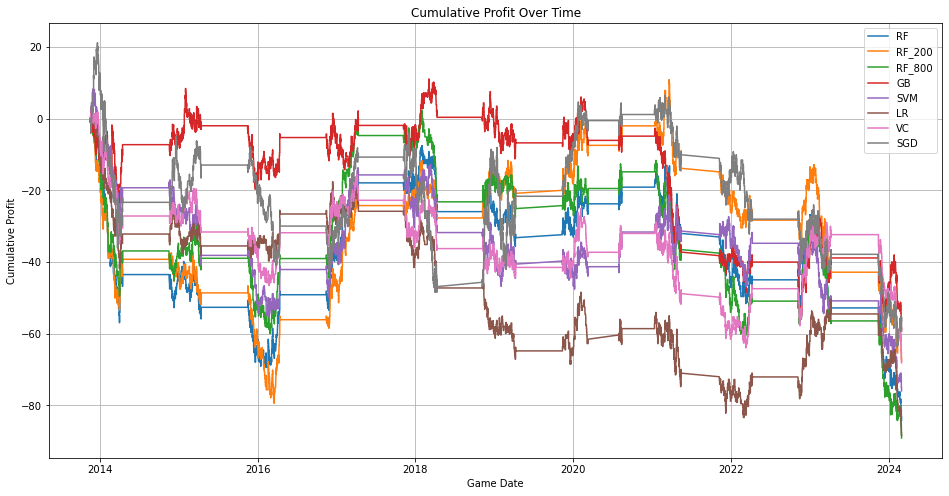

In [118]:
plt.figure(figsize=(16, 8))

for model in models:
    model_abbv = model["abbreviation"]
    if model_abbv in in_depth_models_for_analysis:
        plt.plot(main_df['GAME_DATE'], main_df[f"{model_abbv}_PROFIT_TRACKING"], label = model_abbv)
    
plt.title('Cumulative Profit Over Time')
plt.xlabel('Game Date')
plt.ylabel('Cumulative Profit')
plt.legend()
plt.grid(True)
plt.show()

#### 